<a href="https://colab.research.google.com/github/auroramugnai/arXiv_classification/blob/main/arXiv_classification/keywords_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Clone the github repository and move to the inner directory.

In [1]:
!git clone https://github.com/auroramugnai/arXiv_classification.git
%cd arXiv_classification/arXiv_classification

Cloning into 'arXiv_classification'...
remote: Enumerating objects: 171, done.
remote: Counting objects: 100% (171/171), done.
remote: Compressing objects: 100% (162/162), done.
remote: Total 171 (delta 104), reused 13 (delta 5), pack-reused 0
Receiving objects: 100% (171/171), 5.03 MiB | 7.04 MiB/s, done.
Resolving deltas: 100% (104/104), done.
/content/arXiv_classification/arXiv_classification


# 1) Build the dataset

In [2]:
import json
import os
import random
import zipfile

import dask.bag as db
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import utils

In [ ]:
SEED = 42 # fix random seed for reproducibility

## Download the dataset
The following line of code comes from clicking on "Copy API command" in https://www.kaggle.com/datasets/Cornell-University/arxiv.

In [3]:
!kaggle datasets download -d Cornell-University/arxiv

Dataset URL: https://www.kaggle.com/datasets/Cornell-University/arxiv
License(s): CC0-1.0
 99% 1.27G/1.28G [00:10<00:00, 160MB/s]
100% 1.28G/1.28G [00:10<00:00, 135MB/s]


Unzip the downloaded file.

In [4]:
with zipfile.ZipFile('./arxiv.zip', 'r') as zip_ref:
    zip_ref.extractall()

The unzipping creates an "arxiv-metadata-oai-snapshot.json". We now create a dask bag out of it.

In [5]:
path = "./arxiv-metadata-oai-snapshot.json"
arxiv_data = db.read_text(path).map(json.loads)
arxiv_data.take(1)

({'id': '0704.0001',
  'submitter': 'Pavel Nadolsky',
  'authors': "C. Bal\\'azs, E. L. Berger, P. M. Nadolsky, C.-P. Yuan",
  'title': 'Calculation of prompt diphoton production cross sections at Tevatron and\n  LHC energies',
  'comments': '37 pages, 15 figures; published version',
  'journal-ref': 'Phys.Rev.D76:013009,2007',
  'doi': '10.1103/PhysRevD.76.013009',
  'report-no': 'ANL-HEP-PR-07-12',
  'categories': 'hep-ph',
  'license': None,
  'abstract': '  A fully differential calculation in perturbative quantum chromodynamics is\npresented for the production of massive photon pairs at hadron colliders. All\nnext-to-leading order perturbative contributions from quark-antiquark,\ngluon-(anti)quark, and gluon-gluon subprocesses are included, as well as\nall-orders resummation of initial-state gluon radiation valid at\nnext-to-next-to-leading logarithmic accuracy. The region of phase space is\nspecified in which the calculation is most reliable. Good agreement is\ndemonstrated with d

## Get rid of some unnecessary information

In [6]:
# Get the latest version of the articles.
get_latest_version = lambda x: x['versions'][-1]['created']

# Only keep articles published after 2022.
is_after_2020 = lambda x: int(get_latest_version(x).split(' ')[3]) > 2020

# Only keep some information.
cut_info = lambda x: {'id': x['id'],
                      'title': x['title'],
                      'category':x['categories'].split(' '),
                      'abstract':x['abstract'],}

# Only keep Computer Science macro-category.
is_only_cs = lambda x: all([s.startswith("cs.") for s in x['categories'].split(' ')])

arxiv_data_filtered = (arxiv_data.filter(is_after_2020).filter(is_only_cs).map(cut_info).compute())


# Create a pandas dataframe and save it to csv.
df = pd.DataFrame(arxiv_data_filtered)
df.to_csv("./cs_arxiv_data_filtered.csv", index=False)
df.head()

,id,title,category,abstract
0,0710.3901,A recursive linear time modular decomposition ...,[cs.DM],A module of a graph G is a set of vertices t...
1,0711.2010,A Polynomial Time Algorithm for Graph Isomorphism,[cs.CC],We claimed that there is a polynomial algori...
2,0802.3414,A Universal In-Place Reconfiguration Algorithm...,"[cs.CG, cs.MA, cs.RO]",In the modular robot reconfiguration problem...
3,0803.3946,On the `Semantics' of Differential Privacy: A ...,"[cs.CR, cs.DB]","Differential privacy is a definition of ""pri..."
4,0805.1877,Perfect tag identification protocol in RFID ne...,[cs.NI],Radio Frequency IDentification (RFID) system...


# Read the dataset containing the keywords

In [ ]:
link = f"./kws_cs_0-110k.csv"
data = pd.read_csv(link, dtype=str)

data.head()

110000


,title,category,abstract,abstract_processed,title_processed,TEXT,keywords
0,A recursive linear time modular decomposition ...,['cs.DM'],A module of a graph G is a set of vertices t...,module graph g set vertex set neighbour outsid...,recursive linear time modular decomposition al...,recursive linear time modular decomposition al...,"['algorithm', 'decomposition', 'modular', 'tree']"
1,A Polynomial Time Algorithm for Graph Isomorphism,['cs.CC'],We claimed that there is a polynomial algori...,claim polynomial algorithm test graphs isomorp...,polynomial time algorithm graph isomorphism,polynomial time algorithm graph isomorphism cl...,"['isomorphic', 'graph', 'eigenvalue', 'test']"
2,A Universal In-Place Reconfiguration Algorithm...,"['cs.CG', 'cs.MA', 'cs.RO']",In the modular robot reconfiguration problem...,modular robot reconfiguration problem give n c...,universal in place reconfiguration algorithm s...,universal in place reconfiguration algorithm s...,"['reconfiguration', 'algorithm', 'cube', 'modu..."
3,On the `Semantics' of Differential Privacy: A ...,"['cs.CR', 'cs.DB']","Differential privacy is a definition of ""pri...",differential privacy definition privacy algori...,semantics differential privacy bayesian formul...,semantics differential privacy bayesian formul...,"['privacy', 'differential', 'bayesian', 'seman..."
4,Perfect tag identification protocol in RFID ne...,['cs.NI'],Radio Frequency IDentification (RFID) system...,radio frequency identification rfid system pop...,perfect tag identification protocol rfid network,perfect tag identification protocol rfid netwo...,"['rfid', 'tag', 'protocol', 'mac']"


# scegliere se samplare e se pareggiare

In [ ]:
sample = True
balance = False


if sample:
    num_data = 20000 # number of articles that we want to keep
    print(f"The dataset contains {len(df)} articles.")

    # Sample the dataset only if its length exceeds num_data.
    if(len(df) > num_data):
        n_sample = num_data
        random.seed(SEED)
        df = df.sample(n=n_sample, axis=0)

    df.to_csv("./dataset_to_classify.csv", index=False)
    print(f"The dataset contains {len(df)} articles.")

data.head()

,title,category,abstract,abstract_processed,title_processed,TEXT,keywords
0,Look Outside the Room: Synthesizing A Consiste...,['cs.CV'],Novel view synthesis from a single image has...,novel view synthesis single image recently att...,look outside room synthesize consistent long t...,look outside room synthesize consistent long t...,"['camera', 'generate', 'trajectory', 'deep']"
1,How Much Space Has Been Explored? Measuring th...,"['cs.CE', 'cs.LG']",Forming a molecular candidate set that conta...,form molecular candidate set contain wide rang...,space explored measure chemical space covered ...,space explored measure chemical space covered ...,"['molecular', 'database', 'generate', 'covered']"
2,Multi-View Reasoning: Consistent Contrastive L...,"['cs.CL', 'cs.AI', 'cs.LG']",Math word problem solver requires both preci...,math word problem solver require precise relat...,multi view reasoning consistent contrastive le...,multi view reasoning consistent contrastive le...,"['learning', 'solver', 'contrastive', 'alignme..."
3,Region attention and graph embedding network f...,"['cs.CV', 'cs.AI']",Micro-expression recognition (\textbf{MER}) ...,micro expression recognition mer attract lot r...,region attention graph embed network occlusion...,region attention graph embed network occlusion...,"['facial', 'embed', 'network', 'micro']"
4,Safe Online Bid Optimization with Return-On-In...,"['cs.LG', 'cs.AI']","In online marketing, the advertisers' goal i...",online marketing advertiser goal usually trade...,safe online bid optimization return on investm...,safe online bid optimization return on investm...,"['optimization', 'advertiser', 'guarantee', 'b..."


## Balance the dataset

17578


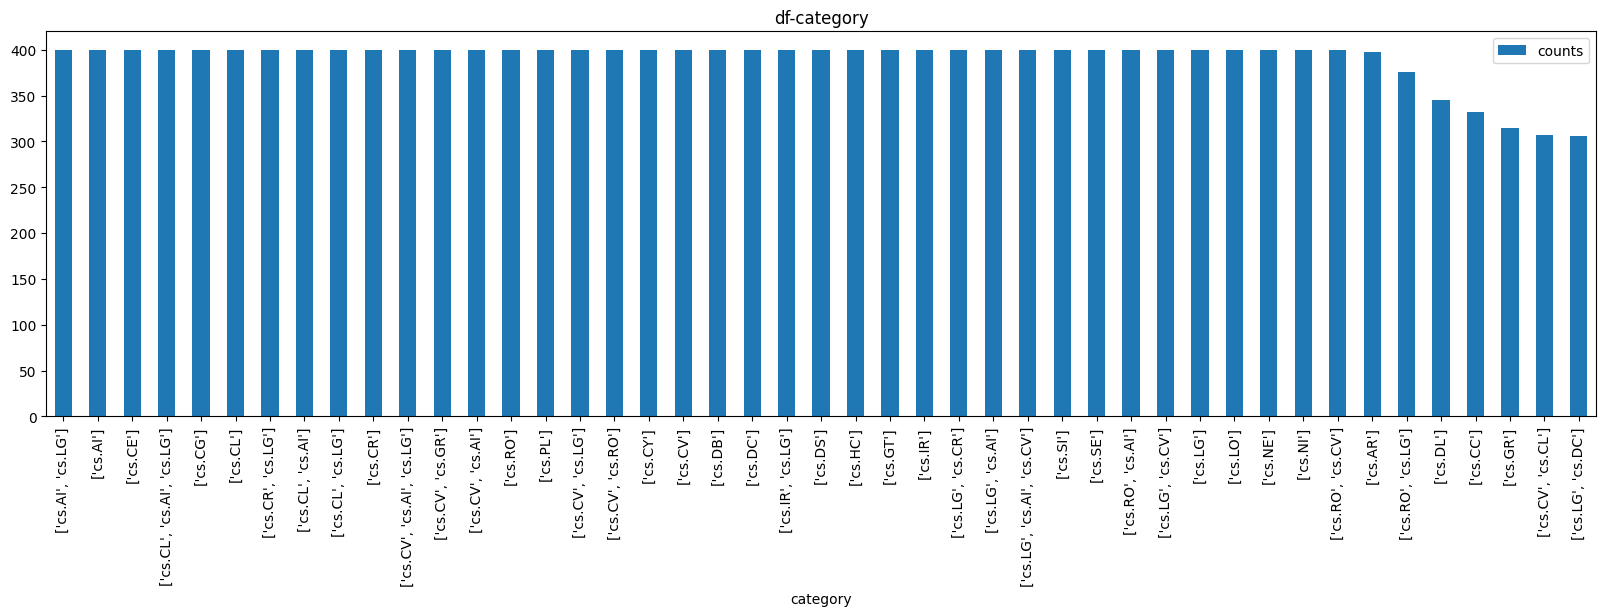

In [ ]:
if balance:

    num_min = 300
    num_max = 400

    df = data.copy(deep=False)

    utils.categories_as_strings(df) # take "category" as a column of strings

    # Drop the lists of categories that have less than num_min counts.
    cut_num_min = lambda x : len(x) > num_min
    df = df.groupby('category').filter(cut_num_min)

    # Sample num_max times those categories that have more than num_max counts.
    sample_num_max = lambda x: x.sample(min(len(x), num_max))
    df = df.groupby('category', as_index = False, group_keys=False)
    df = df.apply(sample_num_max).reset_index(drop=True)

    print(f"The dataset contains {len(df)} articles.")
    df.head()

    # Get list-of-categories occurrences.
    utils.categories_as_strings(df) # take "category" as a column of strings
    _ = utils.plot_df_counts(df, col="category")


    # Get single-category occurrences.
    utils.categories_as_lists(df) # take "category" as a column of lists
    df_exp = df.explode("category")
    dict_counts_exp = utils.plot_df_counts(df_exp, col="category")

# Single label classification X=abs+tit y=keyword

In [ ]:
!pip install scikit-multilearn

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC

In [ ]:
# Preparing X (features)
X = df["TEXT"].values

# Preparing y (labels)
y = df['keywords'].values

#Split data into train/test.
X_train, X_test, y_train_tot, y_test_tot = train_test_split(X, y,
                                                            test_size=0.5,
                                                            random_state=SEED)

In [ ]:
# Select only the first keyword for every article.
y_train = [eval(x)[0] for x in y_train_tot]
y_test = [eval(x)[0] for x in y_test_tot]

Do the classification.

In [ ]:
model = Pipeline([('tfidf', TfidfVectorizer(stop_words='english')),
                         ('svm_model', LinearSVC(verbose=1))])

y_pred = run_model_one(model, X_train, X_test, y_train, y_test)

print('accuracy: ', accuracy_score(y_test, y_pred))

df_pred = pd.DataFrame({'processed_text': X_test,
                        'true_kws': y_test_tot,
                        'first_true_kw': y_test,
                        'predicted_kw': y_pred})

[LibLinear]accuracy:  0.4055


In [ ]:
df_pred = df_pred.reset_index(drop=True)
df_pred.head()

,processed_text,true_kws,first_true_kw,predicted_kw
0,one class knowledge distillation face presenta...,"['face', 'discriminative', 'learn', 'domain']",face,face
1,hyperparameter tuning renyi differential priva...,"['privacy', 'hyperparameter', 'sgd', 'differen...",privacy,privacy
2,knowledge distillation base contextual relevan...,"['contextual', 'search', 'commerce', 'distilla...",contextual,matching
3,chunk base nearest neighbor machine translatio...,"['datastore', 'chunk', 'translation', 'nearest']",datastore,corpus
4,epasad ellipsoid decision boundary base proces...,"['epasad', 'firewall', 'sensor', 'dimension']",epasad,cybersecurity
5,inche high performance encoding relational dat...,"['encryption', 'database', 'homomorphic', 'inc...",encryption,encryption
6,weight dependent gates network pruning paper s...,"['pruning', 'imagenet', 'weight', 'gate']",pruning,convolutional
7,effective graph learning base approach tempora...,"['antgraph', 'predict', 'temporal', 'wsdm']",antgraph,temporal
8,enhance keyphrase extraction academic articles...,"['keyphrase', 'textrank', 'articles', 'enhance']",keyphrase,keyphrase
9,lipi lightweight privacy preserving data aggre...,"['iot', 'lipi', 'aggregation', 'share']",iot,iot


In [ ]:
# Get the number of predicted kws that are contained in the list of true kws.
is_in_true_kws = lambda x: x.predicted_kw in x.true_kws
num_true = df_pred.apply(is_in_true_kws, axis=1).value_counts().loc[True]

# Turn it to percentage.
print(f"{round((num_true/len(df_pred))*100, 2)}% of predicted kws are true kws")

61.98% of predicted kws are true kws


# Compute the distance between the true and the predicted keywords

In [ ]:
import time

import nltk
import spacy
from gensim.models import Word2Vec

In [ ]:
# Lists of the keywords on which we want to compute the similarity.
kws_pred = df_pred['predicted_kw'].values
kws_true = df_pred['first_true_kw'].values

## 1) Word2Vec


In [ ]:
t0 = time.time()

# Create the corpus using our processed texts.
corpus = list(df['TEXT'].values)

# Tokenize the corpus.
nltk.download('punkt')
tokenized_corpus = [nltk.word_tokenize(text.lower()) for text in corpus]

# Train the Word2Vec model on the created corpus.
model = Word2Vec(tokenized_corpus, min_count=1)

print(f"time: {time.time()-t0} s")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


tempo: 33.90641975402832 s


Compute the meaning similarity.

In [ ]:
simil_meaning_list = []

for i, (kp,kb) in enumerate(zip(kws_pred,kws_true)):
    sim = model.wv.similarity(kp,kb) # meaning similarity
    sim = float("{0:.2f}".format(sim))
    if (i<5): print(f"The similarity between '{kp}' and '{kb}' is: {sim}")
    simil_meaning_list.append(sim)

print(f"\nMEAN OF SIMILARITIES: {np.mean(simil_meaning_list)}")

The similarity between 'face' and 'face' is: 1.0
The similarity between 'privacy' and 'privacy' is: 1.0
The similarity between 'matching' and 'contextual' is: 0.23
The similarity between 'corpus' and 'datastore' is: 0.48
The similarity between 'cybersecurity' and 'epasad' is: 0.32

MEAN OF SIMILARITIES: 0.6081650000000001


## 2) Spacy


In [ ]:
nlp = spacy.load('en_core_web_md') # 0.57

token = lambda word: nlp(word)[0]  # shortcut to convert string to spacy.Token
score_words = lambda w1, w2: token(w1).similarity(token(w2))

score_list = []
for i, (kp,kb) in enumerate(zip(kws_pred,kws_true)):
    score = score_words(kp,kb)
    score = float("{0:.2f}".format(score))
    if (i<5): print(f"The score between '{kp}' and '{kb}' is: {score}")
    score_list.append(score)

print(f"\nMEAN SCORE BETWEEN STRINGS: {np.mean(score_list)}")

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


Lo score tra 'face' e 'face' è: 1.0
Lo score tra 'privacy' e 'privacy' è: 1.0
Lo score tra 'matching' e 'contextual' è: 0.46
Lo score tra 'corpus' e 'datastore' è: 0.34
Lo score tra 'cybersecurity' e 'epasad' è: 0.0


<ipython-input-84-47c17e8fc1ea>:6: UserWarning: [W008] Evaluating Token.similarity based on empty vectors.
  score_words = lambda w1, w2: token(w1).similarity(token(w2))



MEAN OF SCORE BETWEEN STRINGS: 0.5972790000000001
